In [2]:
print("📦 예시 bbox_dict key:", list(bbox_dict.keys())[:5])

📦 예시 bbox_dict key: ['LIDC-IDRI-0538_slice0076.npy', 'LIDC-IDRI-0538_slice0075.npy', 'LIDC-IDRI-0500_slice0051.npy', 'LIDC-IDRI-0500_slice0050.npy', 'LIDC-IDRI-0500_slice0049.npy']


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 2970.8091, min: -169.8050
[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 2109.6394, min: -338.1821
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 1962.3634, min: 30.1266
[DEBUG] act shape: torch.Size([512, 14, 14]), grad shape: torch.Size([512, 14, 14])
[DEBUG] CAM max: 1734.4661, min: -233.0258
[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 2113.6018, min: 37.6101
[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 1789.8469, min: -227.0815
[DEBUG] act shape: torch.Size([512, 13, 13]), grad shape: torch.Size([512, 13, 13])
[DEBUG] CAM max: 1196.6503, min: -128.6212
[DEBUG] act shape: torch.Size([512, 12, 12]), grad shape: torch.Size([512, 12, 12])
[DEBUG] CAM max: 1995.8820, min

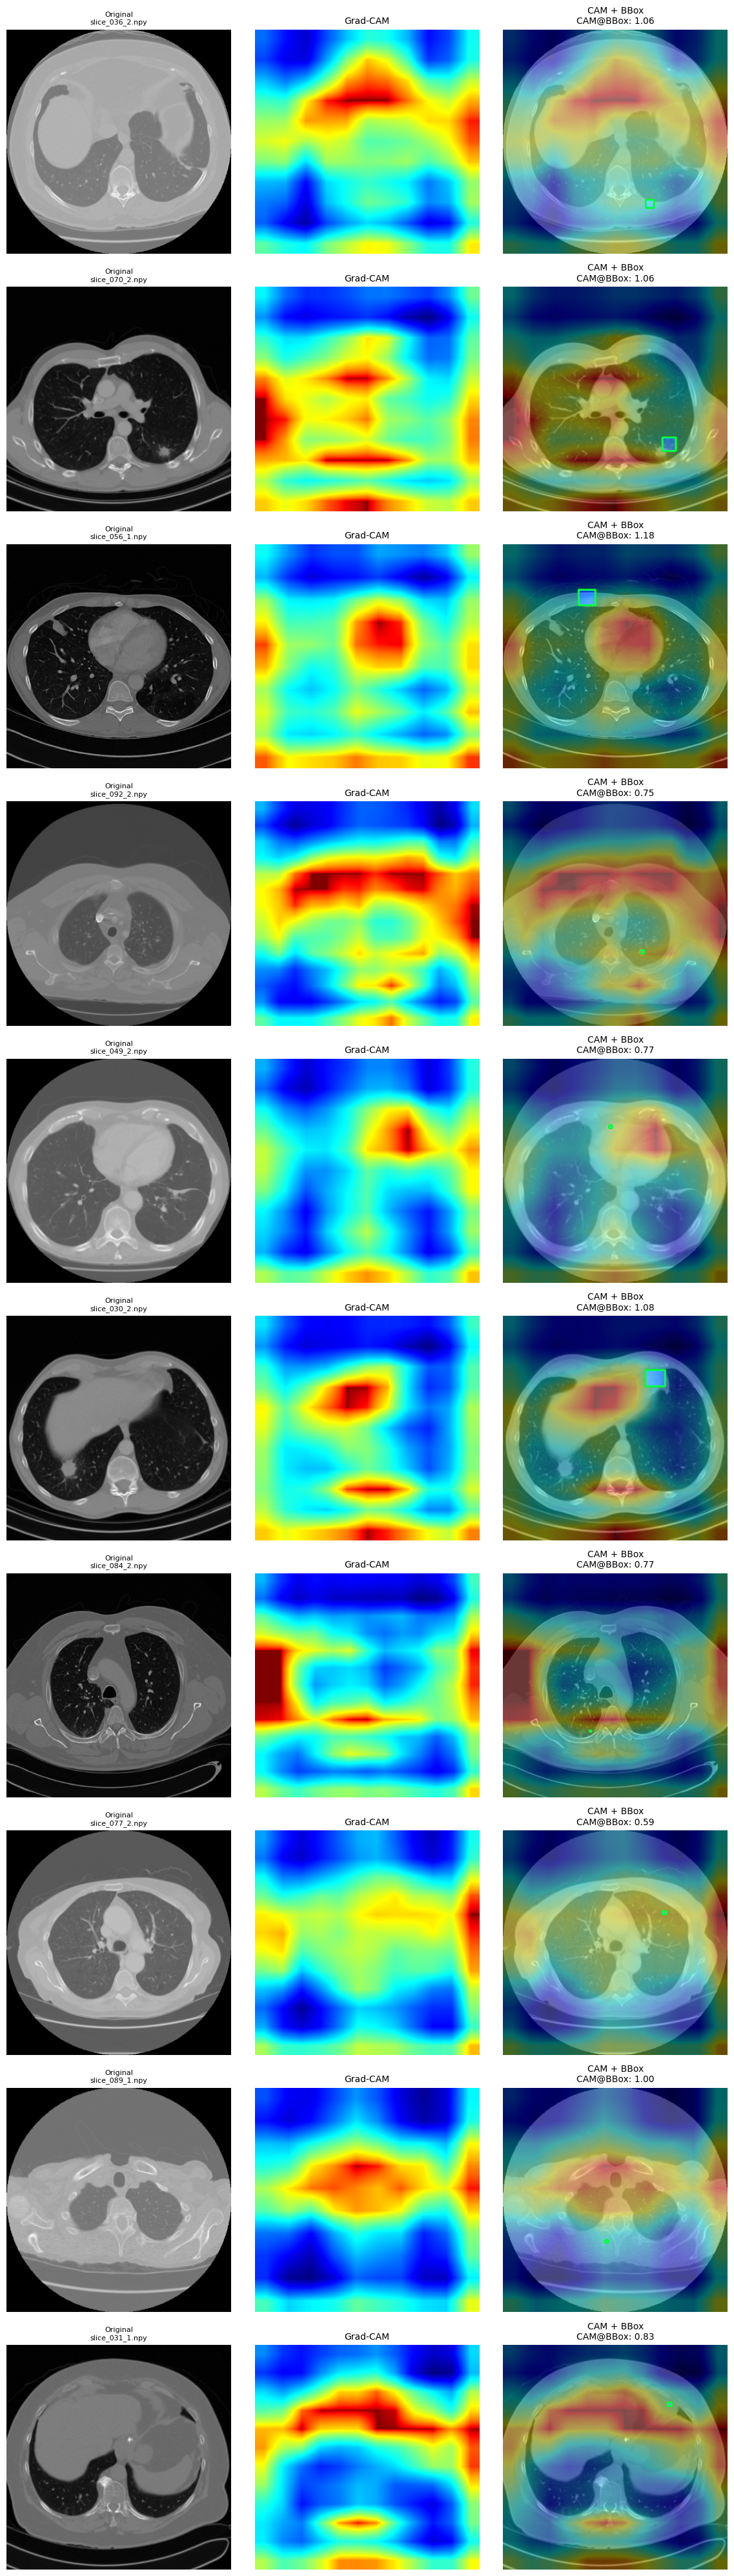

: 

In [ ]:
# ✅ Grad-CAM + BBox + CAM@BBox 자동 리포트 생성기

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bbox_key'] = bbox_df.apply(lambda row: f"{row['pid']}_{row['slice']}.npy", axis=1)
bbox_grouped = bbox_df.groupby('bbox_key')['bb'].apply(list).to_dict()
bbox_df['bb'] = bbox_df['bb'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    slice_base = os.path.basename(path).split("_")[:2]  # slice_060_5.npy -> [slice, 060]
    return f"{pid}_{'_'.join(slice_base)}.npy"

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)
filtered_df = df[df['bbox_key'].isin(bbox_grouped.keys())]
selected = filtered_df.sort_values(by="loss", ascending=False).head(10)

# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).cuda().eval()
model.load_state_dict(torch.load(model_path))

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().cuda()

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # BBox + mask
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    for raw_box in bbox_grouped[bbox_key]:
        try:
            # 문자열인 경우 → 파싱
            box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box

            # 박스가 한 겹 더 싸여있는 경우 → 벗기기
            if isinstance(box[0][0], list):  # [[[y1, y2], [x1, x2]]]
                box = box[0]

            (y1, y2), (x1, x2) = box

            # BBox 그리기
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
            mask[y1:y2 + 1, x1:x2 + 1] = 1

        except Exception as e:
            print(f"[WARNING] bbox malformed: {raw_box} → {e}")
            continue

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    cam_all_mean = cam.mean()
    cam_bbox_mean = cam[mask==1].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title("Original", fontsize=10)
    axs[row_idx, 0].set_title(f"Original\n{os.path.basename(npy_path)}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

# 저장
out_path = os.path.join(save_dir, "summary_report_bbox.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")


In [2]:
# BBox 있는 샘플이 얼마나 있는지 확인
print("전체 평가 샘플 수:", len(df))
print("BBox 있는 평가 샘플 수:", len(filtered_df))

# 혹시 0개면?
if len(filtered_df) == 0:
    print("❌ samplewise_metrics.csv 안에 bbox_dict에 해당하는 샘플 없음")

전체 평가 샘플 수: 5332
BBox 있는 평가 샘플 수: 0
❌ samplewise_metrics.csv 안에 bbox_dict에 해당하는 샘플 없음
